In [1]:
import numpy as np
np.random.seed(123)

# data
from tensorflow.keras.datasets import mnist

# plot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

## MNIST Data

http://yann.lecun.com/exdb/mnist/

https://en.wikipedia.org/wiki/MNIST_database

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# resize each image from 28 x 28 to vector and normalize to maximum 1
X_train = X_train.reshape(X_train.shape[0], 28*28) / 255
X_test = X_test.reshape(X_test.shape[0], 28*28) / 255

# validation split proportion
validation_split = 0.1

# create validation data

# observations
obs = y_train.shape[0]
idx = np.arange(obs)

# shuffle indices
np.random.shuffle(idx)

# data
split_idx = int(validation_split * obs)
X_val, X_train = X_train[ :split_idx], X_train[split_idx: ]
y_val, y_train = y_train[ :split_idx], y_train[split_idx: ]

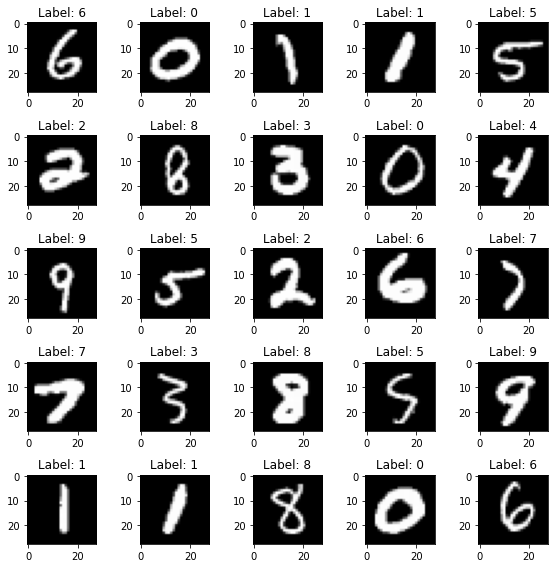

In [3]:
# show data
plt.figure(figsize=[8, 8])
rows, columns = 5, 5

for i in range(rows*columns):
    plt.subplot(rows,columns,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape(28, 28),cmap='gray')
    
plt.tight_layout()
plt.show()

## Neural Network Layer

Given input data $X$, a neural network layer does three things in every training epoch:

* send some output $f(X)$ to the next layer (forward pass) (with parameters $\theta$), and
* send the loss gradient with respect to the input ${\partial L \over \partial X}$ back to the previous layer (back propogation),
* update parameters $\theta$ with gradient descent to minimize loss function (back propogation).

---

### Dummy Layer

First we create a dummy layer class that leaves the network unchanged. This will serve as the base class for our other layer classes.


**Forward pass:**
$$
    Y = f(X) = X
$$

**Back propagation:**
$$
{\partial L \over \partial X} = {\partial L \over \partial Y} \cdot {d Y \over d X} = {\partial L \over \partial Y}
$$

In [4]:
# create a dummy class to ensure methods exist
class Layer:
    
    def __init__(self, name="Dummy"):
        '''
        Empty __init__ for dummy class
        
        X -> Y
        '''
        
        # layer name
        self.name = name
    
    def forward(self, input_layer):
        '''
        Performs a forward pass without any transformations
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
        
        Returns
        ----------
            output_layer : array of shape (observations, output units). Same as input_layer.
        '''
        
        # returns input layer with no transformations
        return input_layer
    
    def backward(self, input_layer, grad_output):
        '''
        Performs a backward pass, returning gradient w.r.t. inputs
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
            
            grad_output : array of shape (observations, output units)
        
        Returns
        ----------        
            grad_input : array of shape (observations, input units)
        '''
        
        return grad_output
    
    def reset(self):
        pass

## Activation Function

The activation function performs some nonlinear transformation on the input $X$.

The activation function is usually thought of as a network layer in itself. It is the second half of a network layer that generates an output and sends it to the next layer. However, we will think of it as it's own layer for organizational purposes and because it can function as such.

---

### ReLU Activation Function:

The first is ReLU (Rectified Linear Unit) activation function. It is one of simplest activation functions, but it is effective and less computationally expensive.

**Forward pass:**
$$
\begin{align}
    Y = f(X) &= X^+,
    \quad \text{where} \;\;
    X^+_{ij} = \begin{cases}
        X_{ij} & X_{ij} > 0 \\
        0 & X_{ij} \le 0
    \end{cases}
\end{align}
$$

**Backward pass:**
$$
\begin{align}
    {\partial L \over \partial X}
    &= {\partial L \over \partial Y} \cdot {d Y \over d X},
    \quad \text{where}\quad
    {d Y \over d X} = \begin{cases}
        1 & X_{ij} > 0 \\
        0 & X_{ij} \le 0
    \end{cases}
\end{align}
$$

In [5]:
# create a dummy class to ensure methods exist
class ReLU(Layer):
    
    def __init__(self, name="ReLU"):
        '''
        Empty __init__
        '''
        
        # layer name
        self.name = name
    
    def forward(self, input_layer):
        '''
        Outputs a ReLU forward pass on input
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
        
        Returns
        ----------
            output_layer : array of shape (observations, output units)
        '''
        
        # returns ReLU transform
        return np.maximum(input_layer, 0)
    
    def backward(self, input_layer, grad_output):
        '''
        Performs a backward pass, returning gradient w.r.t. inputs
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
            
            grad_output : array of shape (observations, output units)
        
        Returns
        ----------        
            grad_input : array of shape (observations, input units)
        '''
        
        return grad_output * (input_layer > 0)

## Dense Layer

Dense layer performs an affine transformation, connecting every unit in the input layer to the output by a linear transformation.


**Forward pass:**
$$
\begin{align}
    Y = f(X) = X \cdot W + b \cdot \mathbf{1}^T,
\end{align}
$$

where
$X \in \mathbb{R}^{m \times n}, W \in \mathbb{R}^{n \times r},  b \in \mathbb{R}^{r \times 1}, \mathbf{1} \in \mathbb{R}^{m \times 1}$.



**Backward pass:**
$$
\begin{align}
    {\partial L \over \partial X}
    &= {\partial L \over \partial Y} \cdot {\partial Y \over \partial X},
    \qquad 
    {\partial Y \over \partial X} = W^{T}
\end{align}
$$

**Parameter Gradients:**
$$
\begin{align}
    {\partial L \over \partial W}
    &= {d Y \over d W} \cdot {\partial L \over \partial Y},
    \qquad
    {d Y \over d W} = X^T
    \\
    {\partial L \over \partial b}
    &= \mathbf{1}^T \cdot {\partial L \over \partial Y}
\end{align}
$$


### Extensions

**Regularization**


In [6]:
# create a dummy class to ensure methods exist
class Dense(Layer):
    
    def __init__(self, input_units, output_units, learning_rate=0.1, name="Dense"):
        '''
        Dense layer performs affine transformation on input layer
        
        Parameters
        ----------
        input_units : number of neurons or units from input_layer
        
        output_units : number of neurons for current layer
        '''
        
        self.input_units = input_units
        self.output_units = output_units
        
        # initialize weights randomly from normal distribution
        xavier_var = 2 / (input_units+output_units)
        self.weights = np.random.randn(self.input_units, self.output_units) * np.sqrt(xavier_var)
        self.biases = np.zeros(self.output_units)
        
        self.learning_rate = learning_rate
        
        # layer name
        self.name = name
        
    
    def forward(self, input_layer):
        '''
        Outputs a affine transformation with weights and biases
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
        
        Returns
        ----------
            output_layer : array of shape (observations, output units)
        '''
        
        # affine transformation
        return np.dot(input_layer, self.weights) + self.biases
    
    def backward(self, input_layer, grad_output):
        '''
        Performs backward propogation, updates layer parameters, and returning gradient of loss w.r.t. inputs
        
        Parameters
        ----------
            input_layer : array of shape (observations, input units)
            
            grad_output : array of shape (observations, output units)
        
        Returns
        ----------        
            grad_input : array of shape (observations, input units)
        '''
        
        # gradient w.r.t. inputs
        grad_input = np.dot(grad_output, self.weights.T)
        
        # gradient w.r.t. parameters
        grad_weights = np.dot(input_layer.T, grad_output)
        grad_biases = np.dot(np.ones(grad_output.shape[0]), grad_output)
        
        # step opposite of gradient
        self.weights = self.weights - self.learning_rate * grad_weights 
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input
        

    def reset(self):
        
        # initialize weights randomly from normal distribution
        self.weights = np.random.randn(self.input_units, self.output_units) * 0.01
        self.biases = np.zeros(self.output_units)

## Prediction Output

The layer takes inputs from the last hidden layers and outputs a prediction for each observation. We use softmax to output probabilities, for $K$ logits.

**Softmax**
$$
\begin{align}
    \sigma(z) &= {e^{z_k} \over \sum_{j=1}^K {e^{z_j}}}, k = 1, ..., K
    = {1 \over \sum_{j=1}^K e^{z_j}}\begin{bmatrix}
        e^{z_1} \\
        \vdots \\
        e^{z_K}
    \end{bmatrix}
\end{align}
$$



**Cross Entropy Loss**

Loss function
$$
\begin{align}
    L(Z) &= {1 \over m} \sum_{i=1}^m \ell(Z_i)
    \\
    \ell(z)
    &= -\sum_{k}^K \mathbb{1}_{[y = k]} \log \sigma(z) \\
    &= -\sum_{k}^K \mathbb{1}_{[y = k]} \log \left( {\exp(z_k) \over \sum_{j=1}^K {\exp(z_j)}} \right)
    = -z_y + \log\left({\sum_{j=1}^K {\exp(z_j)}}\right)
\end{align}
$$

Gradient:
$$
\begin{align}
    {\partial L(Z) \over \partial Z}
    &= {1 \over m} \sum_{i=1}^m {\partial \ell(Z_i) \over \partial Z_i}
    \\
    {\partial \ell(z) \over \partial z}
    &= -\mathbb{1}_{[y = k]} + \sigma_k, \; k = 1, ..., K
\end{align}
$$

In [7]:
def softmax(logits):
    '''
    Calculate probabilites of target class from logits (log-odds)
    
    Parameters
    ----------
        logist : log-odds of target classes
        
    Returns
    ----------
        prob : probability of target classes
    '''
    return np.exp(logits)/np.exp(logits).sum(axis=-1, keepdims=True)

def softmax_cross_entropy_loss(logits, target):
    '''
    Calculate loss function from logits
    
    Parameters
    ----------
        logist : log-odds of target classes
        
        target : index of actual target classes
        
    Returns
    ----------
        loss : value of cross entropy loss
    '''
    # number of logit rows for indexing
    rows = np.arange(logits.shape[0])
    
    # - target class logit + log sum of class logits
    return np.mean(- logits[rows, target] + np.log(np.exp(logits).sum(axis=-1)))

def grad_softmax_cross_entropy_loss(logits, target):
    '''
    Calculate gradient matrix of loss function w.r.t. logits
    
    Parameters
    ----------
        logist : log-odds of target class
        
        target : actual class of target
        
    Returns
    ----------
        grad_softmax : matrix of gradient of loss w.r.t. logits
    '''
    # number of logit rows for indexing
    rows = np.arange(logits.shape[0])
    
    # indicator matrix for target class
    indicator = np.zeros_like(logits)
    indicator[rows, target] = 1
    
    # average of (- indicator + softmax)
    return (-indicator + softmax(logits)) / logits.shape[1]

In [8]:
def forward(network, data):
    '''
    Feed data forward through network
    
    Parameters
    ----------
        network : list of neural network layers
        
        data : feature data to feed forward
        
    Returns
    ----------
        activations : list of activation outputs of each network layer
    '''
    input_layer = data
    activations = []
    
    for layer in network:
        
        input_layer = layer.forward(input_layer)
        activations.append(input_layer)
        
    return activations


def predict(network, data):
    '''
    Predict class with neural network from data
    
    Parameters
    ----------
        network : list of neural network layers
        
        data : feature data to feed forward
        
    Returns
    ----------
        predicted_classes : index of highest predicted logit (log-odds) class
    '''
    logits = forward(network, data)[-1]
    
    # largest logit
    return np.argmax(logits, axis=-1)


def train(network, data, target):
    '''
    Predict class with neural network from data
    
    Parameters
    ----------
        network : list of neural network layers
        
        data : feature data to feed forward
        
        target : array of indexes of target category
        
    Returns
    ----------
        loss : value of cross entropy loss from current network 
    '''
    
    activations = forward(network, data)
    logits = activations[-1]
    
    loss_grad = grad_softmax_cross_entropy_loss(logits, target)
    
    input_layers = [data] + activations[:-1]
    
    for i in range(len(network)):
        
        layer = network[-i-1]
        input_layer = input_layers[-i-1]
        
        loss_grad = layer.backward(input_layer, loss_grad)
        
    # return loss
    return softmax_cross_entropy_loss(logits, target)

## Create network and train

In [9]:
# number of labels
categories = len(np.unique(y_train))
features = X_train.shape[1]

network = [
    Dense(features, 50),
    ReLU(),
    Dense(50, 100),
    ReLU(),
    Dense(100, categories),
]

Epoch 20

Training Accuracy: 0.99452
Val Accuracy: 0.97350
Loss: 0.00014


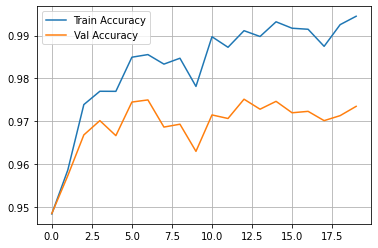

Wall time: 25 s


In [10]:
%%time

# batch size for mini-batch SGD
batchsize = 50
epochs = 20

# reset network parameters
for layer in network:
    layer.reset()

data_size = y_train.shape[0]
idx = np.arange(data_size)

# progress
train_prog, val_prog = [], []

for epoch in range(epochs):
    
    # randomize indices
    np.random.shuffle(idx)
    
    for i in range(0, data_size, batchsize):
        
        # batch data
        batch_idx = idx[i : i+batchsize]
        x_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
        
        # train on batch (mini-batch stochastic gradient descent)
        loss = train(network, x_batch, y_batch)
    
    
    clear_output()
    
    # prediction accuracy    
    train_acc = np.mean(predict(network, X_train)==y_train)
    val_acc = np.mean(predict(network, X_val)==y_val)

    print(f"Epoch {epoch+1}\n")
    print(f"Training Accuracy: {train_acc:.5f}")
    print(f"Val Accuracy: {val_acc:.5f}")
    print(f"Loss: {loss:.5f}")
    
    # plot progress
    
    train_prog.append(train_acc)
    val_prog.append(val_acc)
    
    plt.plot(train_prog, label="Train Accuracy")
    plt.plot(val_prog, label="Val Accuracy")
    
    plt.grid()
    plt.legend()

    plt.show()

In [11]:
# test data set accuracy

test_pred = predict(network, X_test)
test_acc = np.mean(test_pred==y_test)
print(f"Val Accuracy: {test_acc:.5f}")

error_idx = np.where(test_pred!=y_test)[0]

Val Accuracy: 0.97290


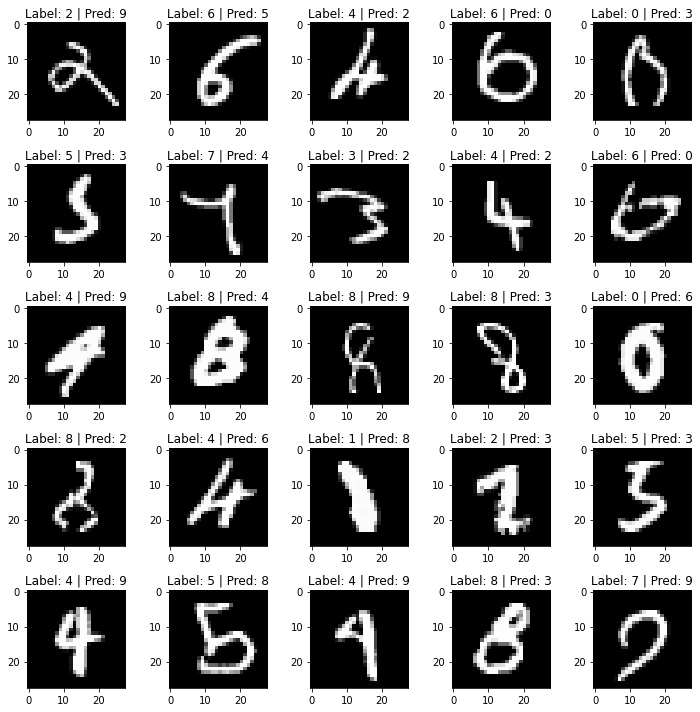

In [12]:
rows, cols = 5, 5

plt.figure(figsize=(10, 10))

for i in range(rows*cols):
    
    plt.subplot(rows, cols, i+1)
    
    n = error_idx[i]
    plt.title(f"Label: {y_test[n]} | Pred: {test_pred[n]}")
    
    plt.imshow(X_test[n].reshape(28, 28), cmap='gray')

plt.tight_layout()    
plt.show()
    